In [13]:
import os
import sys
import random
from ultralytics import YOLO
from IPython.display import Image

# Add the 'src' directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Now we can import your config file
from config import Config

In [14]:
# --- 1. Define Model Path (robust) ---
model_name = 'best.pt'
candidate_paths = [
    os.path.join('..', 'models', 'weights', model_name),                       # ../models/weights/best.pt
    os.path.join('..', Config.MODEL_PHASE1_WEIGHTS),                           # runs/detect/...
    Config.MODEL_PHASE1_WEIGHTS,                                               # relative runs/...
    str(Config.REPO_ROOT / 'models' / 'weights' / model_name)                  # absolute path variant
]
model_path = next((p for p in candidate_paths if p and os.path.exists(p)), None)

print("Checked model paths:")
for p in candidate_paths:
    print("  ", p, "->", "OK" if os.path.exists(p) else "MISSING")

if not model_path:
    raise FileNotFoundError("Model file not found. Put best.pt in ../models/weights/ or update model_path.")
print("Using model:", model_path)

# --- 2. Define Test Image Path (use Config.IMAGES_DIR which is absolute) ---
images_dir = Config.IMAGES_DIR
if not os.path.isdir(images_dir):
    raise FileNotFoundError(f"Images dir not found: {images_dir}")
test_image_name = random.choice(os.listdir(images_dir))
image_path = os.path.join(images_dir, test_image_name)
print("Using image:", image_path)

Checked model paths:
   ../models/weights/best.pt -> OK
   ../runs/detect/yolov8_phase1_coarse/weights/best.pt -> OK
   runs/detect/yolov8_phase1_coarse/weights/best.pt -> MISSING
   /Users/macm4/repositories/Machine Learning Model/modisch-model/models/weights/best.pt -> OK
Using model: ../models/weights/best.pt
Using image: /Users/macm4/repositories/Machine Learning Model/modisch-model/dataset/colorful_fashion_dataset_for_object_detection/JPEGImages/10708.jpg



image 1/1 /Users/macm4/repositories/Machine Learning Model/modisch-model/dataset/colorful_fashion_dataset_for_object_detection/JPEGImages/10708.jpg: 512x352 1 jacket, 1 shirt, 1 pants, 1 shoe, 22.1ms
Speed: 1.0ms preprocess, 22.1ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 352)
Results saved to /Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict5
Detections: 4
 0: bbox=[135.49740600585938, 288.8489685058594, 239.1450653076172, 488.15264892578125], conf=0.983, class=2 (pants)
 1: bbox=[132.6262664794922, 169.07518005371094, 228.71783447265625, 306.60577392578125], conf=0.916, class=1 (shirt)
 2: bbox=[103.87701416015625, 139.31871032714844, 262.18841552734375, 303.06170654296875], conf=0.907, class=0 (jacket)
 3: bbox=[159.6435089111328, 472.27459716796875, 219.4982452392578, 536.3378295898438], conf=0.783, class=6 (shoe)
Annotated image saved to: /Users/macm4/repositories/Machine Learning Model/modisch-model/runs/detect/predict5/10708.j

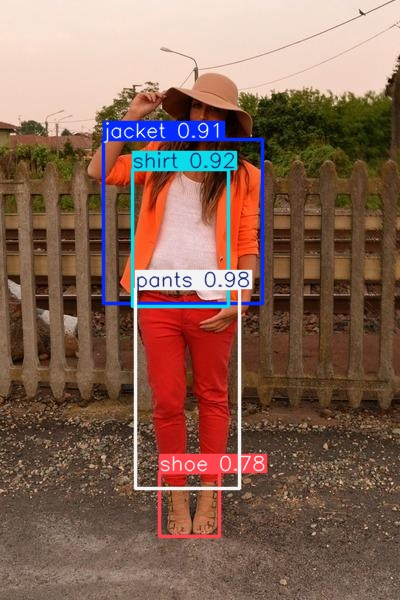

In [15]:

# --- 3. Load model and run prediction with debug info ---
model = YOLO(model_path)

# Lower max_det and explicit conf to avoid NMS/timeouts dropping detections
results = model.predict(source=image_path, conf=0.2, iou=0.45, max_det=200, save=True)

res = results[0]
n_boxes = len(res.boxes)
print(f"Detections: {n_boxes}")
if n_boxes == 0:
    print("No boxes detected — try lowering conf or checking model weights.")
else:
    # print box coords, conf, class id/name
    for i, box in enumerate(res.boxes):
        xyxy = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0].cpu().numpy()) if hasattr(box, 'conf') else None
        cls_id = int(box.cls[0].cpu().numpy()) if hasattr(box, 'cls') else None
        cls_name = model.names[cls_id] if cls_id is not None and cls_id in model.names else str(cls_id)
        print(f" {i}: bbox={xyxy.tolist()}, conf={conf:.3f}, class={cls_id} ({cls_name})")

# Show annotated image produced by YOLO
annotated_dir = res.save_dir  # directory where YOLO saved annotated image
annotated_path = os.path.join(annotated_dir, test_image_name)
print("Annotated image saved to:", annotated_path)

from IPython.display import Image, display
display(Image(filename=annotated_path))